In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve,roc_auc_score

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
train = pd.read_csv('/kaggle/input/playground-series-s3e12/train.csv')
train.head(5)        

/kaggle/input/playground-series-s3e12/sample_submission.csv
/kaggle/input/playground-series-s3e12/train.csv
/kaggle/input/playground-series-s3e12/test.csv


,id,gravity,ph,osmo,cond,urea,calc,target
0,0,1.013,6.19,443,14.8,124,1.45,0
1,1,1.025,5.40,703,23.6,394,4.18,0
2,2,1.009,6.13,371,24.5,159,9.04,0
3,3,1.021,4.91,442,20.8,398,6.63,1
4,4,1.021,5.53,874,17.8,385,2.21,1


In [3]:
train.describe()

,id,gravity,ph,osmo,cond,urea,calc,target
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,206.500000,1.017894,5.955459,651.545894,21.437923,278.657005,4.114638,0.444444
std,119.655756,0.006675,0.642260,234.676567,7.514750,136.442249,3.217641,0.497505
min,0.000000,1.005000,4.760000,187.000000,5.100000,10.000000,0.170000,0.000000
25%,103.250000,1.012000,5.530000,455.250000,15.500000,170.000000,1.450000,0.000000
50%,206.500000,1.018000,5.740000,679.500000,22.200000,277.000000,3.130000,0.000000
75%,309.750000,1.022000,6.280000,840.000000,27.600000,385.000000,6.630000,1.000000
max,413.000000,1.040000,7.940000,1236.000000,38.000000,620.000000,14.340000,1.000000


In [4]:
train.isnull().sum()

id         0
gravity    0
ph         0
osmo       0
cond       0
urea       0
calc       0
target     0
dtype: int64

In [5]:
train.target.value_counts()

0    230
1    184
Name: target, dtype: int64

<AxesSubplot:>

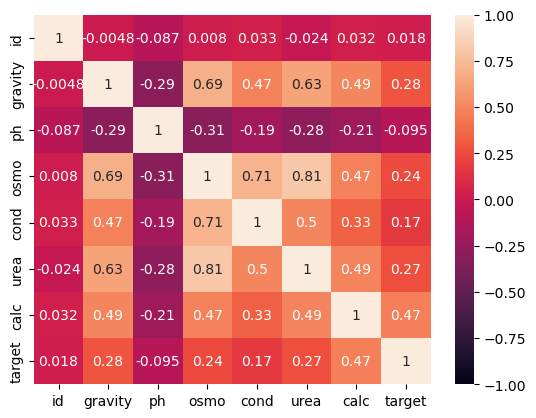

In [6]:
sns.heatmap(train.corr(),vmin = -1, vmax = 1, annot = True)

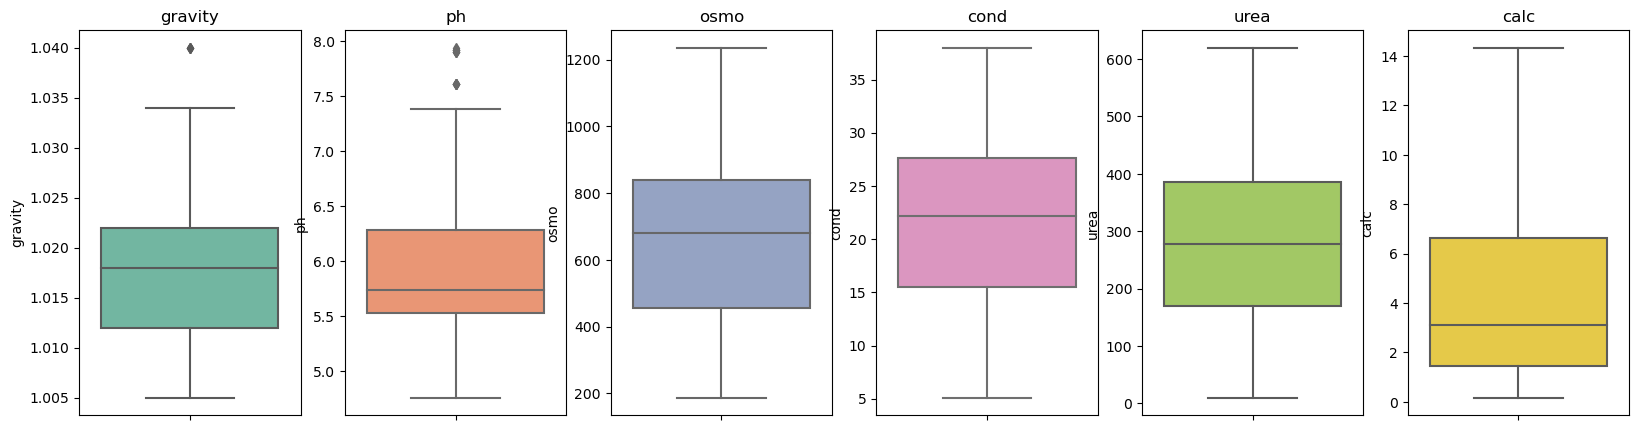

In [7]:
X = train.iloc[:, 1:-1]
colors = sns.color_palette('Set2', len(X.columns))
fig, axs = plt.subplots(ncols=len(X.columns), figsize=(20,5))

for i, col in enumerate(X.columns):
    sns.boxplot(y=col, data=X, color=colors[i], ax=axs[i])
    axs[i].set_title(col)

plt.show()

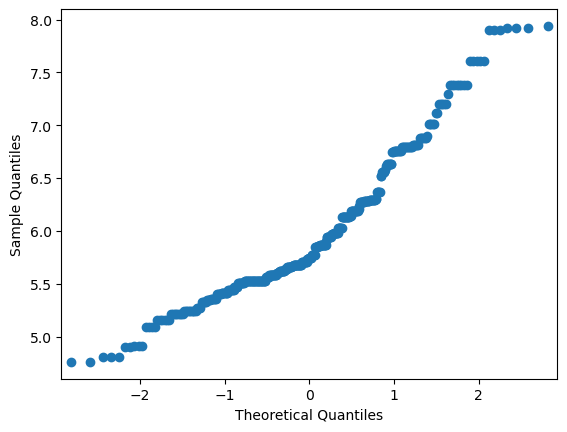

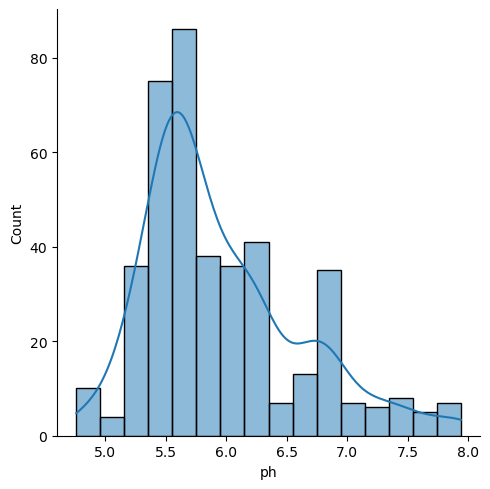

In [8]:
# Check on ph
sm.qqplot(X['ph'])
sns.displot(X['ph'], kde=True)
plt.show()

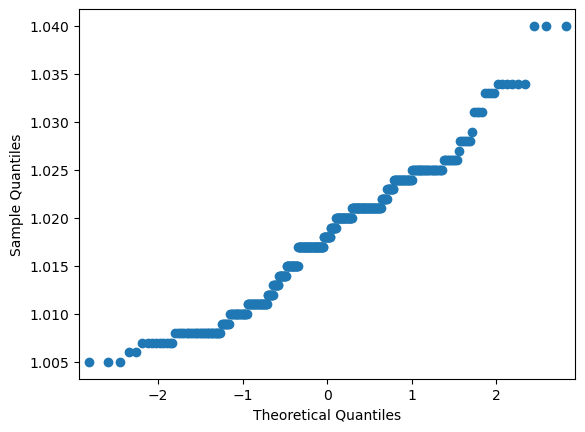

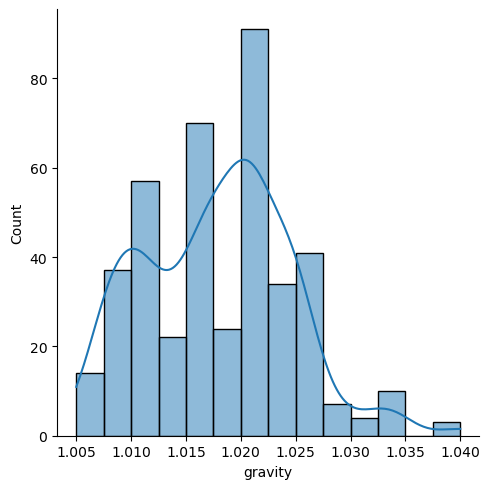

In [9]:
# Check on Gravity
sm.qqplot(X['gravity'])
sns.displot(X['gravity'], kde=True)
plt.show()

# Modelling

## Split the Data

In [10]:
y = train.target
attributes = X.columns.tolist()

In [11]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((289, 6), (125, 6), (289,), (125,))

## Decision Tree

In [12]:
scaler = Pipeline(steps=[
    ('scaler', StandardScaler())
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('preprocess', scaler, attributes)])

pipelineDT = Pipeline(steps=[('preprocessor', preprocessor),
                           ('dt', DecisionTreeClassifier())])

In [13]:
param_dt = {'dt__max_depth': [5,8,10], 
            'dt__max_features': [0.2,0.4,0.8],
            'dt__max_leaf_nodes': [2,5,8],
            'dt__min_samples_split' :[5,8,10]}

In [14]:
modeldt = GridSearchCV(pipelineDT,param_dt,cv=5)
modeldt.fit(X_train,y_train)

print(modeldt.best_params_)

{'dt__max_depth': 10, 'dt__max_features': 0.8, 'dt__max_leaf_nodes': 5, 'dt__min_samples_split': 8}


In [15]:
best_model = modeldt.best_estimator_
train_pred = best_model.predict(X_train)
y_pred = best_model.predict(X_test)
        
train_acc = accuracy_score(y_train, train_pred)
test_accuracy = accuracy_score(y_test, y_pred)

print('Decision Tree Train Accuracy :',train_acc)
print('Decision Tree Test Accuracy :',test_accuracy)
print(classification_report(y_test, y_pred))

Decision Tree Train Accuracy : 0.740484429065744
Decision Tree Test Accuracy : 0.736
              precision    recall  f1-score   support

           0       0.80      0.67      0.73        67
           1       0.68      0.81      0.74        58

    accuracy                           0.74       125
   macro avg       0.74      0.74      0.74       125
weighted avg       0.75      0.74      0.74       125



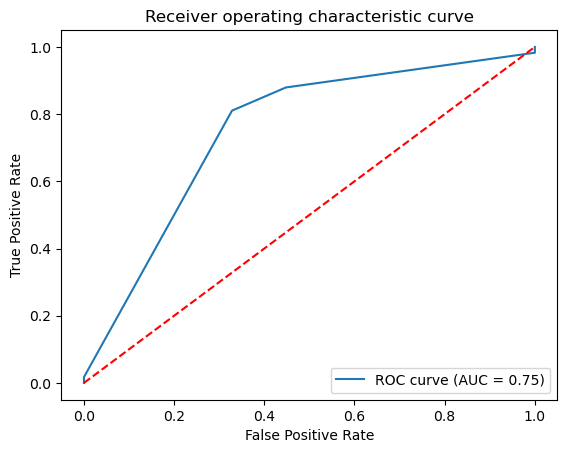

AUC: 0.7509006690684508


In [16]:
y_pred_proba = modeldt.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], '--',color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

print('AUC:', auc)

## Gradient Boost

In [17]:
pipelineGB = Pipeline(steps=[('preprocessor', preprocessor),
                           ('gb', GradientBoostingClassifier())])

In [18]:
param_gb = {'gb__learning_rate': [0.05,0.1,0.2], 
            'gb__n_estimators': [10,15,20],
            'gb__min_samples_split': [2,5,8],
            'gb__min_samples_leaf' :[8,12,15],
            'gb__max_depth' :[2,5,8]}

In [19]:
modelgb = GridSearchCV(pipelineGB,param_gb,cv=5)
modelgb.fit(X_train,y_train)

print(modelgb.best_params_)

{'gb__learning_rate': 0.1, 'gb__max_depth': 2, 'gb__min_samples_leaf': 12, 'gb__min_samples_split': 2, 'gb__n_estimators': 10}


In [20]:
best_model = modelgb.best_estimator_
train_pred = best_model.predict(X_train)
y_pred = best_model.predict(X_test)
        
train_acc = accuracy_score(y_train, train_pred)
test_accuracy = accuracy_score(y_test, y_pred)

print('Gradient Boost Train Accuracy :',train_acc)
print('Gradient Boost Test Accuracy :',test_accuracy)
print(classification_report(y_test, y_pred))

Gradient Boost Train Accuracy : 0.7370242214532872
Gradient Boost Test Accuracy : 0.784
              precision    recall  f1-score   support

           0       0.79      0.82      0.80        67
           1       0.78      0.74      0.76        58

    accuracy                           0.78       125
   macro avg       0.78      0.78      0.78       125
weighted avg       0.78      0.78      0.78       125



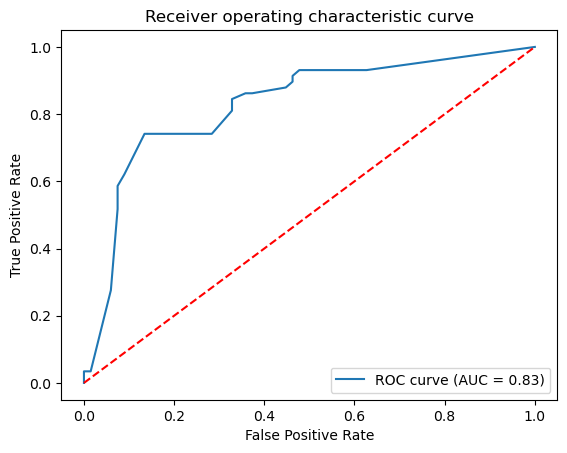

AUC: 0.8278435409161091


In [21]:
y_pred_proba = modelgb.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], '--',color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

print('AUC:', auc)

## LightGBM

In [22]:
pipelineGBM = Pipeline(steps=[('preprocessor', preprocessor),
                           ('gbm', LGBMClassifier())])

In [23]:
param_gbm = {'gbm__learning_rate': [0.05,0.1,0.2], 
            'gbm__n_estimators': [20,30,40],
            'gbm__num_leaves': [2,5,8],
            'gbm__max_bin' :[10,20,30],
            'gbm__max_depth' :[2,5,8]}

In [24]:
modelgbm = GridSearchCV(pipelineGBM,param_gbm,cv=5)
modelgbm.fit(X_train,y_train)

print(modelgbm.best_params_)

{'gbm__learning_rate': 0.2, 'gbm__max_bin': 10, 'gbm__max_depth': 2, 'gbm__n_estimators': 40, 'gbm__num_leaves': 5}


In [25]:
best_model = modelgbm.best_estimator_
train_pred = best_model.predict(X_train)
y_pred = best_model.predict(X_test)
        
train_acc = accuracy_score(y_train, train_pred)
test_accuracy = accuracy_score(y_test, y_pred)

print('LightGBM Train Accuracy :',train_acc)
print('LightGBM Boost Test Accuracy :',test_accuracy)
print(classification_report(y_test, y_pred))

LightGBM Train Accuracy : 0.7854671280276817
LightGBM Boost Test Accuracy : 0.792
              precision    recall  f1-score   support

           0       0.82      0.79      0.80        67
           1       0.77      0.79      0.78        58

    accuracy                           0.79       125
   macro avg       0.79      0.79      0.79       125
weighted avg       0.79      0.79      0.79       125



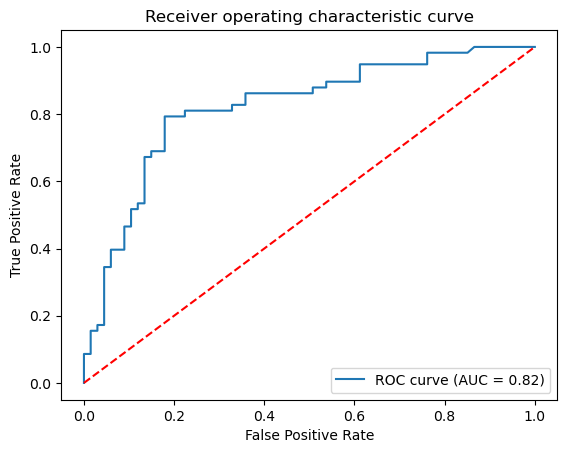

AUC: 0.8217961914565105


In [26]:
y_pred_proba = modelgbm.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], '--',color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

print('AUC:', auc)

## XGBoost

In [27]:
pipelineGBM = Pipeline(steps=[('preprocessor', preprocessor),
                           ('xgb', XGBClassifier())])

In [28]:
param_xgb = {'xgb__learning_rate': [0.05,0.1,0.2], 
            'xgb__max_leaves' :[2,5,8],
            'xgb__max_depth' : [2,5,8],
            'xgb__gamma' : [2,5,8]}

In [29]:
modelxgb = GridSearchCV(pipelineGBM,param_xgb,cv=5)
modelxgb.fit(X_train,y_train)

print(modelxgb.best_params_)

{'xgb__gamma': 5, 'xgb__learning_rate': 0.05, 'xgb__max_depth': 2, 'xgb__max_leaves': 2}


In [30]:
best_model = modelxgb.best_estimator_
train_pred = best_model.predict(X_train)
y_pred = best_model.predict(X_test)
        
train_acc = accuracy_score(y_train, train_pred)
test_accuracy = accuracy_score(y_test, y_pred)

print('XGBoost Train Accuracy :',train_acc)
print('XGBoost Boost Test Accuracy :',test_accuracy)
print(classification_report(y_test, y_pred))

XGBoost Train Accuracy : 0.7370242214532872
XGBoost Boost Test Accuracy : 0.784
              precision    recall  f1-score   support

           0       0.79      0.82      0.80        67
           1       0.78      0.74      0.76        58

    accuracy                           0.78       125
   macro avg       0.78      0.78      0.78       125
weighted avg       0.78      0.78      0.78       125



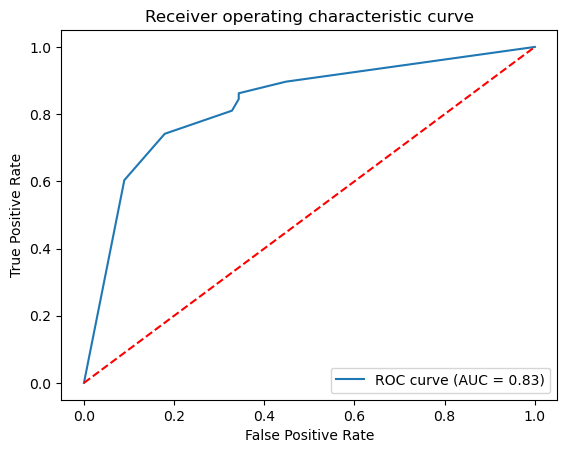

AUC: 0.8309315491507978


In [31]:
y_pred_proba = modelxgb.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], '--',color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

print('AUC:', auc)

# Submission

In [32]:
test = pd.read_csv('/kaggle/input/playground-series-s3e12/test.csv')
test = test.iloc[:,1:]
test

,gravity,ph,osmo,cond,urea,calc
0,1.017,5.24,345,11.5,152,1.16
1,1.020,5.68,874,29.0,385,3.46
2,1.024,5.36,698,19.5,354,13.00
3,1.020,5.33,668,25.3,252,3.46
4,1.011,5.87,567,29.0,457,2.36
...,...,...,...,...,...,...
271,1.029,6.27,853,21.4,364,7.31
272,1.012,5.62,410,14.0,195,1.45
273,1.031,5.68,874,29.0,380,4.49
274,1.019,5.47,543,21.4,170,1.64


In [33]:
pred = best_model.predict(test)
pred

array([0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0])

In [34]:
submit = pd.read_csv('/kaggle/input/playground-series-s3e12/sample_submission.csv')
submit['target'] = pred
submit.to_csv('submission.csv', index=False)